In [1]:
import numpy as np
import os
import sys
import tarfile
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image as PImage
import PIL.ImageDraw as PImageDraw
from IPython.display import display, Image, HTML
import h5py

plt.rcParams['figure.figsize'] = (16.0, 4.0)
%matplotlib inline

In [2]:
from DigitStructUnpacker import DigitStructWrapper
def get_Image_Bbox_List(path):
    """
    This is a helper function which will help in return the list of dictionary, which contains the metadata of the 
    individual data from the dataset of the form:
        {
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
        }
      ]
    }
    """
    return DigitStructWrapper(path).unpack_all()
    

In [3]:
train_Files_MetaData=get_Image_Bbox_List("data/train/digitStruct.mat")

inside the unpack function


This file contains the preprocessing functions which are required in order to get the data ready for the Convolutional Neural Network. 
#### PreProcessing Steps:
##### 1) Creating One Bounding Box out of the Individual BBoxes(<=5 boxes only).
##### 2) Increase the size of the Final BBox which encompasses all the digits by 30%, on all sides.
##### 3) Crop the Image, according to the Final BBox(which is increased by 30%).
##### 4) Resize the image to 64*64 and your image is ready for the CNN.
##### 5) If you want more data: then go for Random Cropping of the 64x64->54x54, then resize the 54x54->64x64 and don't forget to retain the same label.

Before going ahead and processing the data, lets us try to visualize the bounding box over the image to get a better idea.

In [4]:
def DisplayBBoxOnImage(imagepath,bboxes):
    """
    This Function Displays the Image and Draws the Bounding Boxes of individual Digits on the image
    """
    #read the image from the disk
    image=PImage.open(imagepath)
    
    #use the ImageDraw module to draw the BBox on the Image
    DrawBBox=PImageDraw.Draw(image)
    
    for bbox in bboxes:
        #form a rectangle based on the info from the bbox dictionary
        """
        We are passing the two corners of the rectangle, top-left (x0,y0) and bottom right (x1,y1) 
        """
        rectangle=[bbox['left'],bbox['top'],bbox['left']+bbox['width'],bbox['top']+bbox['height']]
        
        #Now let us pass the bbox to visualize it 
        DrawBBox.rectangle(rectangle,outline="green")
    #returning the BBox drawn image    
    return image
    
    

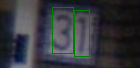

In [5]:
imagepath='data/train_100/5.png'
bboxes=train_Files_MetaData[4]['boxes']
DisplayBBoxOnImage(imagepath,bboxes)

##### We are writing the below function, for helping us eventually. The pandaS dataframe helps us to have great functionality and ease of access

In [6]:
def dict_2_dataframe(path_2_dataset,bboxes_Meta_Data):
    """
    This Function helps us to convert the bboxes_Meta_Data which is a list of Dictionary to a dataFrame.
    """
    #For append the new dictionary to this list and this list is passed for conversion to dataframe
    boxes_Meta_Data=[]
    #for individual Dictionaries of each example
    for individual_Dictionaries in bboxes_Meta_Data:
        #for each bbox_data in an example
        for bboxes in individual_Dictionaries['boxes']:
            boxes_Meta_Data.append({
                'filename' :path_2_dataset+individual_Dictionaries['filename'],
                'width'    :bboxes['width'],
                'height'   :bboxes['height'],
                'top'      :bboxes['top'],
                'left'     :bboxes['left'],
                'label'    :bboxes['label']})
    return pd.DataFrame(boxes_Meta_Data) #conversion to the pandaS DataFrame   

In [8]:
train_DF=dict_2_dataframe('data/train_100/',train_Files_MetaData)
print(train_DF.shape)

(220, 6)


###### Save the Meta_Data in CSV format

In [ ]:
#Left blank for conversion to CSV

#### After Making sure we have separated the above Meta_Data in to a form where each BBox takes its place in different rows. Which basically means that now we have: TotalRows= Number_Of_BBoxes_in the Entire Dataset.

In [9]:
#lets Rename the couple of columns to more relatable names
train_DF.rename(columns={'left':'x0','top':'y0'},inplace=True)
#Lets find and add the bottom right corners of the BBox in the dataFrame
train_DF['x1']=train_DF['x0']+train_DF['width']
train_DF['y1']=train_DF['y0']+train_DF['height']

#Let's perform aggregation to attain the grouping of Images based on the criteria of FileName
aggregate={'x0'   :'min',
           'y0'   :'min',
           'x1'   :'max',
           'y1'   :'max',
           'label':{'labels':lambda x:list(x),
                    'num_digits' : 'count'}
          }
"""
Main Ideology behind doing above aggregation is we want to group the rows of the same image and make just one bounding box by 
finding the min and max points(from the given Bboxes parameters), which eventually contributes to make the left-top corner points 
and right-bottom corner points
'min','max','count'-----are python keywords: 
"""
"""
     refer : https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html for more info
"""
train_DF=train_DF.groupby('filename').agg(aggregate).reset_index()
# Fix the column names after aggregation
train_DF.columns=[x[0] if i<5 else x[1] for i, x in enumerate(train_DF.columns.values)]
"""
for i, x in enumerate(train_DF.columns.values):
    print(i) 
    print('\n')
    print(x)
"""
print(train_DF.head())

                 filename     x0    y0     x1     y1            labels  \
0    data/train_100/1.png  246.0  77.0  419.0  300.0        [1.0, 9.0]   
1   data/train_100/10.png   25.0   4.0   48.0   33.0        [1.0, 6.0]   
2  data/train_100/100.png   18.0   0.0   42.0   23.0  [1.0, 10.0, 9.0]   
3   data/train_100/11.png   22.0   4.0   42.0   31.0        [2.0, 3.0]   
4   data/train_100/12.png   67.0  16.0  110.0   72.0        [6.0, 3.0]   

   num_digits  
0           2  
1           2  
2           3  
3           2  
4           2  


C:\Users\amitp\ComputerVisionTools\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [10]:
def DisplayBBox_AfterMixingIt_2_One(image_path,bbox_data):
    #open the image
    image=PImage.open(image_path)
    #create an object of ImageDraw
    DrawBBox=PImageDraw.Draw(image)
    #print([bbox_data['x0'],bbox_data['y0'],bbox_data['x1'],bbox_data['y1']])
    #Now lets Draw the BBox around the Image
    DrawBBox.rectangle([bbox_data['x0'],bbox_data['y0'],bbox_data['x1'],bbox_data['y1']],outline='green')
    
    return image
    

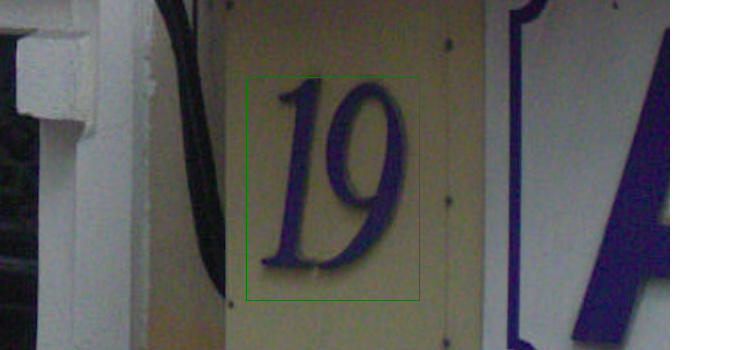

In [12]:
imagepath='data/train_100/1.png'
bboxes=train_DF[train_DF.filename==imagepath]
#print(bboxes['labels'].values[0][0])
DisplayBBox_AfterMixingIt_2_One(imagepath,bboxes)

As it can be seen from the above image that we have success fully converted individual bounding boxes to one big box.
- Next step is to increase the size of the bounding box by 30% and crop the image

    Note: We need to increase the area of the overall rectangle by 30%, therefore we need to increase the height by 15% and width by 15%


In [13]:
train_DF['width_increase']=((train_DF['x1']-train_DF['x0'])*0.3)/2. ##15% of the width
train_DF['height_increase']=((train_DF['y1']-train_DF['y0'])*0.3)/2. ##15% of the height

##Now let's change the height

train_DF['x0']=(train_DF['x0']-train_DF['width_increase']).astype('int') #new x0
train_DF['y0']=(train_DF['y0']-train_DF['height_increase']).astype('int') #new y0
train_DF['x1']=(train_DF['x1']+train_DF['width_increase']).astype('int') #new x1
train_DF['y1']=(train_DF['y1']+train_DF['height_increase']).astype('int') #new y1

##Note don't keep rerunning this area code as everytime you run, new value of bboxes will be considered...
##because inplace changes are made


1.0


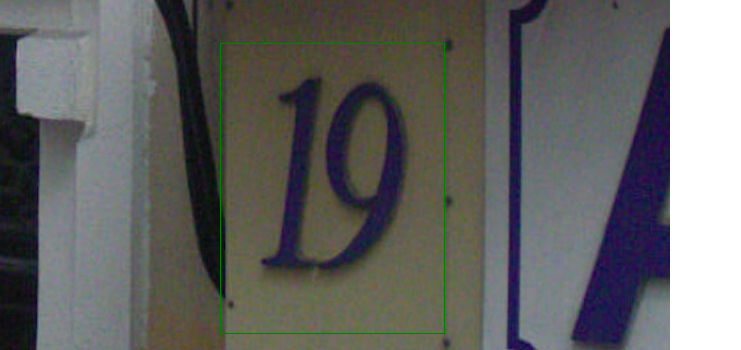

In [14]:
imagepath='data/train_100/1.png'
bboxes=train_DF[train_DF.filename==imagepath]
print(bboxes['labels'].values[0][0])
DisplayBBox_AfterMixingIt_2_One(imagepath,bboxes)

## Image Sizes

The jupyter notebook that we are refering to suggest that we collect information about the height and width of the images, which might help us to discard may be extremely low res images.....

In [15]:
def get_Image_Size(imagepath):
    """
    This function is a helper function which facilitates the work of
    sending the information of the size of the image.
    """
    image=PImage.open(imagepath)
    return image.size
    

In [16]:
def get_Image_Sizes_DF(folderPath):
    """
    This function makes use of the above helper function and makes a 
    Dataframe consists the information of all the image_size
    """
    #empty list that is going to be used to store dictionaries in it
    #it is going to be a list of dictionaries
    image_Sizes_Data=[]
    
    #getting a list of names of the files in the given folder
    images=[img for img in os.listdir(folderPath) if img.endswith('.png')]
    
    for image in images:
        #calling the get_Image_Size() function in order to retrieve the image height 
        #and width based on the imagepath
        width,height=get_Image_Size(folderPath+image)
        image_Sizes_Data.append({
            'filename'    :folderPath+image,
            'image_width' :width,
            'image_height':height,            
        })
        
    #Return results as a pandas DataFrame    
    return pd.DataFrame(image_Sizes_Data)    

In [17]:
folderPath='data/train_100/'
train_Image_Sizes_DF=get_Image_Sizes_DF(folderPath)
print(train_Image_Sizes_DF.head())

""" This needs to be done
# Extract the image sizes
train_sizes = get_image_sizes('data/train/')
test_sizes = get_image_sizes('data/test/')
extra_sizes = get_image_sizes('data/extra/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])

# Delete old dataframes
del train_sizes, test_sizes, extra_sizes

# Display 10 image sizes
image_sizes.head(10)


"""

                 filename  image_height  image_width
0    data/train_100/1.png           350          741
1   data/train_100/10.png            37           74
2  data/train_100/100.png            27           67
3   data/train_100/11.png            33           63
4   data/train_100/12.png            87          171


" This needs to be done\n# Extract the image sizes\ntrain_sizes = get_image_sizes('data/train/')\ntest_sizes = get_image_sizes('data/test/')\nextra_sizes = get_image_sizes('data/extra/')\n\n# Concatenate all the information in a single file\nimage_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])\n\n# Delete old dataframes\ndel train_sizes, test_sizes, extra_sizes\n\n# Display 10 image sizes\nimage_sizes.head(10)\n\n\n"

Let's merge the above table with the new data into our previously created dataframe

In [18]:
print("shape of the bounding box data frame",train_DF.shape)
print("shape of the image_sizes data frame",train_Image_Sizes_DF.shape)

#Inner join the datasets on the filename
train_DF=pd.merge(train_DF,train_Image_Sizes_DF,on='filename',how='inner')

print("combined shape",train_DF.shape)

#delete the dataframes not in use ahead
del train_Image_Sizes_DF


shape of the bounding box data frame (100, 9)
shape of the image_sizes data frame (100, 3)
combined shape (100, 11)


In [19]:
train_DF.head()

,filename,x0,y0,x1,y1,labels,num_digits,width_increase,height_increase,image_height,image_width
0,data/train_100/1.png,220,43,444,333,"[1.0, 9.0]",2,25.95,33.45,350,741
1,data/train_100/10.png,21,0,51,37,"[1.0, 6.0]",2,3.45,4.35,37,74
2,data/train_100/100.png,14,-3,45,26,"[1.0, 10.0, 9.0]",3,3.60,3.45,27,67
3,data/train_100/11.png,19,0,45,35,"[2.0, 3.0]",2,3.00,4.05,33,63
4,data/train_100/12.png,60,7,116,80,"[6.0, 3.0]",2,6.45,8.40,87,171


Before Cropping, it is important to understand that for some images of very small size the bounding box increased could possibly overshoot the dimensions of the image itself which could pose a problem when cropping the image based on the dimensions of the bbox. So in the next step let's handle that situation. 

In [20]:
train_DF.loc[train_DF['x0']<0,'x0']=0
train_DF.loc[train_DF['y0']<0,'y0']=0
train_DF.loc[train_DF['x1']>train_DF['image_width'],'x1']=train_DF['image_width']
train_DF.loc[train_DF['y1']>train_DF['image_height'],'y1']=train_DF['image_height']
train_DF.head()

,filename,x0,y0,x1,y1,labels,num_digits,width_increase,height_increase,image_height,image_width
0,data/train_100/1.png,220,43,444,333,"[1.0, 9.0]",2,25.95,33.45,350,741
1,data/train_100/10.png,21,0,51,37,"[1.0, 6.0]",2,3.45,4.35,37,74
2,data/train_100/100.png,14,0,45,26,"[1.0, 10.0, 9.0]",3,3.60,3.45,27,67
3,data/train_100/11.png,19,0,45,33,"[2.0, 3.0]",2,3.00,4.05,33,63
4,data/train_100/12.png,60,7,116,80,"[6.0, 3.0]",2,6.45,8.40,87,171


### Removing images with digits more than 5

In [21]:
print(train_DF.num_digits.value_counts(sort=False))
train_DF=train_DF[train_DF.num_digits<6]
#print(train_DF.head())

1     8
2    68
3    20
4     4
Name: num_digits, dtype: int64


After verifying that we don't have any bbox going outside of the image dimension. It is also important to eliminate the low resolution images. As eventually when we will be resizing them to 64*64, it would cause good amount of streching for them which eventually result in to loss of information with over stretching.

In [22]:
#We need to try this
train_DF[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,100.00,100.00
mean,134.87,59.86
std,98.49,43.66
min,41.00,20.00
25%,73.75,33.00
50%,111.00,49.50
75%,161.50,73.50
max,741.00,350.00


- Next step is to crop the image and resize it to 64*64 

In [33]:
def crop_Resize_The_Image_Based_On_BBox(image_data,img_size):
    image=PImage.open(image_data['filename']) ##open the image and load in the program
    
    imageCropped=image.crop((image_data['x0'],image_data['y0'],image_data['x1'],image_data['y1'])) #cropping the original image
    imageResized=imageCropped.resize(img_size)
    
    return imageResized
    

['data/train_100/1.png']


(-0.5, 31.5, 31.5, -0.5)

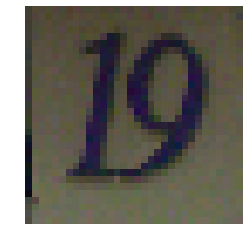

In [30]:
imagepath='data/train_100/1.png'
image_data=train_DF[train_DF.filename==imagepath]
print(image_data['filename'].values)
imageCropped=crop_Resize_The_Image_Based_On_BBox(image_data,(32,32))
plt.imshow(imageCropped)
plt.axis('off')

In [ ]:
#time pass with list comprehensions
matrix=[[[1 for innerCol in range(3)] for col in range(3)] for row in range(3)]
print((matrix))

## Let us now create the dataset

In [39]:
def create_The_Dataset(meta_dataFrame,img_size):
    """
    This is a helper function which helps in creating the dataset according to a desirable format
    """
    #this container will collect all our preprocessed images
    X_data=np.zeros(shape=(meta_dataFrame.shape[0],img_size[0],img_size[1],3),dtype='uint8')
    #this container will collect all our labels... no presence of digits has been implemented with help number 10
    y_data=np.full(shape=(meta_dataFrame.shape[0],5),fill_value=10,dtype=int)
    #print(y_data)
    for i,(index,image_Meta_Data) in enumerate(meta_dataFrame.iterrows()):
        #print(isinstance(index,int))
        X_data[i]=crop_Resize_The_Image_Based_On_BBox(image_Meta_Data,img_size)
        
        #converting it to a numpy array
        labels=np.array((image_Meta_Data['labels']))
        
        #convert 10 to 0... as 0 has been represented as 10 in the labels..and in y_data absence of digit is represented as 10
        labels[labels==10]=0
       # print(labels)
        #Embed this in to y_data
        y_data[i,0:labels.shape[0]]=labels
        
    return X_data,y_data

(100, 64, 64, 3)
[ 1  2  8 10 10]


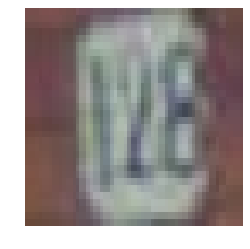

In [47]:
#Image_Size 
img_size=(64,64)
X_train,y_train=create_The_Dataset(train_DF,img_size)
print(X_train.shape)
plt.imshow(X_train[89])
plt.axis('off')
print(y_train[89])

### Storing The Data

In [48]:
# Create file
h5f = h5py.File('data/SVHN_train.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)


# Close the file
h5f.close()